In [1]:
import os

import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import time

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
df= df.sample(n=600000)
print(df.shape)
df.head()

(600000, 15)


,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
1456065,1,80,867,15490,84.87,28700.0,12.0,105.79,1994.11,476.0,386.0,1118.0,897.0,2012,3
2821420,1,218,637,9060,84.73,32800.0,11.0,107.18,2007.01,484.0,146.0,1280.0,1012.0,2015,1
1488242,1,80,1620,12125,134.67,43000.0,10.0,161.98,1994.02,270.0,150.0,1056.0,878.0,2016,3
5449088,11,81,809,15929,72.54,20700.0,14.0,89.26,1988.04,1496.0,146.0,943.0,767.0,2014,6
5194421,11,13,1960,2436,59.79,10000.0,8.0,79.34,1995.06,370.0,224.0,553.0,417.0,2006,1


In [5]:
# df_down2 = df.sample(n=15000)
# print(df_down2.shape)
# df_down2.head()

In [6]:
# df_down3 = df.sample(n=1000)
# print(df_down3.shape)
# df_down3.head()

In [7]:
# df_down4 = df.sample(n=100)
# print(df_down4.shape)
# df_down4.head()

In [8]:
y = df['price']
del df['price']

In [9]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

# 4 ML models

In [10]:
gboost = GradientBoostingRegressor(random_state=0)
xgboost = xgb.XGBRegressor(random_state=0)
lightgbm = lgb.LGBMRegressor(random_state=0)
lasso = Lasso(alpha=1.0, random_state=0)
svm = svm.SVC(kernel='rbf', C=1, gamma=0.1, random_state=0)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':gboost, 'name': 'GradientBoosting'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':lasso, 'name': 'Lasso'}]
#           {'model':svm, 'name': 'SVM'}]

In [11]:
def predict_each(models, x, y, sub_x, sub_y):
    for m in models :
        RMSE = []
        
        for m in models:
            start = time.time()
            m['model'].fit(x.values, y)
            predictions = m['model'].predict(sub_x.values) 
            result = sqrt(mean_squared_error(sub_y, predictions))
            end = round((time.time() - start), 4)
            RMSE.append(m['name'])
            RMSE.append(round(result))
            RMSE.append(end)
    return RMSE

In [12]:
y_pred = predict_each(models, x_train, y_train, x_test, y_test)
y_pred

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


['XGBoost',
 1086,
 31.6341,
 'GradientBoosting',
 1109,
 41.6471,
 'LightGBM',
 1216,
 4.5351,
 'Lasso',
 6640,
 6.6802]

# Keras

In [13]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [15]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [16]:
start = time.time()
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 252000 samples, validate on 168000 samples
Epoch 1/100
252000/252000 [==============================] - 4s 15us/step - loss: 429739236.3492 - acc: 1.9841e-05 - val_loss: 121663610.4524 - val_acc: 5.9524e-05

Epoch 00001: val_loss improved from inf to 121663610.45238, saving model to ./model/01-121663610.4524.hdf5
Epoch 2/100
252000/252000 [==============================] - 2s 8us/step - loss: 102513045.0000 - acc: 1.1111e-04 - val_loss: 95069322.0000 - val_acc: 1.4286e-04

Epoch 00002: val_loss improved from 121663610.45238 to 95069322.00000, saving model to ./model/02-95069322.0000.hdf5
Epoch 3/100
252000/252000 [==============================] - 2s 9us/step - loss: 72890632.0794 - acc: 1.7857e-04 - val_loss: 54359137.6905 - val_acc: 2.2619e-04

Epoch 00003: val_loss improved from 95069322.00000 to 54359137.69048, saving model to ./model/03-54359137.6905.hdf5
Epoch 4/100
252000/252000 [==============================] - 2s 9us/st

252000/252000 [==============================] - 2s 9us/step - loss: 922328.9815 - acc: 8.1349e-04 - val_loss: 1307283.9518 - val_acc: 0.0012

Epoch 00030: val_loss did not improve from 987843.59245
Epoch 31/100
252000/252000 [==============================] - 2s 9us/step - loss: 935434.3615 - acc: 6.5873e-04 - val_loss: 975362.8847 - val_acc: 5.1190e-04

Epoch 00031: val_loss improved from 987843.59245 to 975362.88467, saving model to ./model/31-975362.8847.hdf5
Epoch 32/100
252000/252000 [==============================] - 2s 8us/step - loss: 730118.8268 - acc: 9.2460e-04 - val_loss: 850365.2143 - val_acc: 8.9286e-04

Epoch 00032: val_loss improved from 975362.88467 to 850365.21429, saving model to ./model/32-850365.2143.hdf5
Epoch 33/100
252000/252000 [==============================] - 2s 8us/step - loss: 751074.4975 - acc: 8.6508e-04 - val_loss: 957713.3527 - val_acc: 8.1548e-04

Epoch 00033: val_loss did not improve from 850365.21429
Epoch 34/100
252000/252000 [====================

252000/252000 [==============================] - 2s 8us/step - loss: 317271.1984 - acc: 0.0015 - val_loss: 381715.7975 - val_acc: 0.0024

Epoch 00066: val_loss did not improve from 345499.16146
Epoch 67/100
252000/252000 [==============================] - 2s 8us/step - loss: 357121.0055 - acc: 0.0016 - val_loss: 379795.5262 - val_acc: 0.0013

Epoch 00067: val_loss did not improve from 345499.16146
Epoch 68/100
252000/252000 [==============================] - 2s 8us/step - loss: 327665.4795 - acc: 0.0015 - val_loss: 485073.5690 - val_acc: 0.0020

Epoch 00068: val_loss did not improve from 345499.16146
Epoch 69/100
252000/252000 [==============================] - 2s 8us/step - loss: 311631.6911 - acc: 0.0015 - val_loss: 382070.1230 - val_acc: 0.0021

Epoch 00069: val_loss did not improve from 345499.16146
Epoch 70/100
252000/252000 [==============================] - 2s 8us/step - loss: 457501.8218 - acc: 0.0012 - val_loss: 348489.7109 - val_acc: 0.0018

Epoch 00070: val_loss did not impr

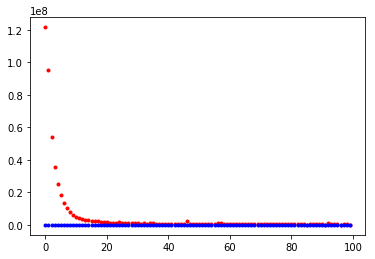

In [17]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [18]:
modelPred = model.predict(x_test)
end = time.time() - start
print(round(end,4))
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

219.5817


363.7326438062723

In [19]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 8700.000, 예상가격: 8965.097
실제가격: 21500.000, 예상가격: 21745.400
실제가격: 39500.000, 예상가격: 39487.496
실제가격: 25000.000, 예상가격: 24834.906
실제가격: 11500.000, 예상가격: 11788.936
실제가격: 4430.000, 예상가격: 4225.404
실제가격: 26800.000, 예상가격: 26903.363
실제가격: 80000.000, 예상가격: 79401.164
실제가격: 12500.000, 예상가격: 12738.808
실제가격: 11000.000, 예상가격: 11124.288


In [24]:
model = load_model('./model/97-234525.8206.hdf5')

In [25]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

361.15822636452873

In [26]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, round(prediction)))

실제가격: 8700.000, 예상가격: 8891.000
실제가격: 21500.000, 예상가격: 21683.000
실제가격: 39500.000, 예상가격: 39236.000
실제가격: 25000.000, 예상가격: 24789.000
실제가격: 11500.000, 예상가격: 11668.000
실제가격: 4430.000, 예상가격: 4196.000
실제가격: 26800.000, 예상가격: 26733.000
실제가격: 80000.000, 예상가격: 79308.000
실제가격: 12500.000, 예상가격: 12553.000
실제가격: 11000.000, 예상가격: 10929.000


Train on 252000 samples, validate on 168000 samples
Epoch 1/10
252000/252000 [==============================] - 3s 10us/step - loss: 493300783.4921 - acc: 2.3810e-05 - val_loss: 120263428.6190 - val_acc: 1.2500e-04

Epoch 00001: val_loss improved from inf to 120263428.61905, saving model to ./model/01-120263428.6190.hdf5
Epoch 2/10
252000/252000 [==============================] - 2s 9us/step - loss: 101969073.2857 - acc: 9.1270e-05 - val_loss: 92154391.5238 - val_acc: 1.6667e-04

Epoch 00002: val_loss improved from 120263428.61905 to 92154391.52381, saving model to ./model/02-92154391.5238.hdf5
Epoch 3/10
252000/252000 [==============================] - 2s 8us/step - loss: 67824616.8889 - acc: 1.9841e-04 - val_loss: 48509565.2262 - val_acc: 2.6190e-04

Epoch 00003: val_loss improved from 92154391.52381 to 48509565.22619, saving model to ./model/03-48509565.2262.hdf5
Epoch 4/10
252000/252000 [==============================] - 2s 8us/step - loss: 37717566.9603 - acc: 1.9841e-04 - val_los

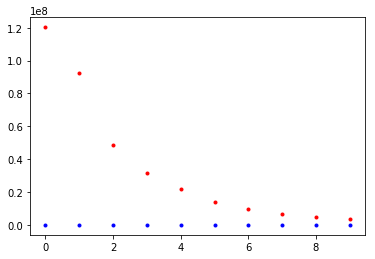

28.286


1759.2009708096502

In [23]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

start = time.time()
history = model.fit(x_train, y_train, validation_split=0.4, epochs=10, batch_size=1000, callbacks=[checkpointer])
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

modelPred = model.predict(x_test)
end = time.time() - start
print(round(end,4))
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE